<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/domain_adaptation_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:

gdrive_file = '/content/gdrive/MyDrive/MNISTM/mnist_m.tar.gz'
data_dir = '/content'

In [4]:
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/test_mnist_m.tar.gz
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/train_mnist_m.tar.gz

In [18]:
import tarfile
my_tar = tarfile.open(gdrive_file, "r:gz")
my_tar.extractall(data_dir) # specify which folder to extract to
my_tar.close()

Source is MNIST, Target is MNIST-M

In [69]:
image_size = 28
batch_size = 4

In [70]:
tf_source = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                          ])
tf_target = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          ])

Downloading MNIST and creating a data loader

In [71]:
ds_source_train = tv.datasets.MNIST(root="./", train=True, transform=tf_source, download=True)
ds_source_val = tv.datasets.MNIST(root="./", train=False, transform=tf_source, download=True)
dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)


Working on MNIST-M Dataset

In [72]:
import torch.utils.data as data
from PIL import Image
import os


class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [73]:
ds_target_train = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

ds_target_val = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_test'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_test_labels.txt'),
                         transform=tf_target)



dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


In [74]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt


def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

(<Figure size 576x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc8274fa90>,
       dtype=object))

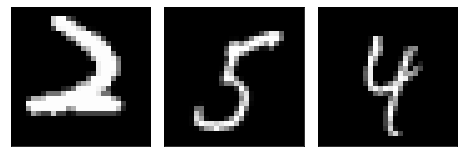

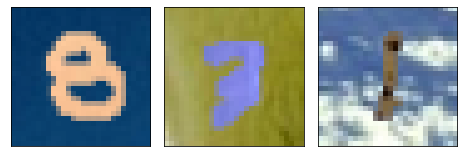

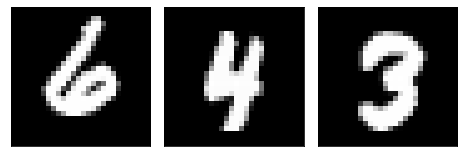

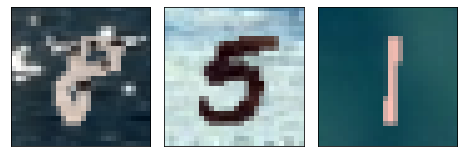

In [75]:
## Showing first n images of the dataset
dataset_first_n(ds_source_train, 3, cmap='gray')
dataset_first_n(ds_target_train, 3)
dataset_first_n(ds_source_val, 3, cmap='gray')
dataset_first_n(ds_target_val, 3)

## Model

Our model will consist of three parts, as in the figure:

* A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
* A digit-classification head (3x FC, ReLU)
* A domain classification head (2x FC, ReLU), with gradient reversal layer (GRL)

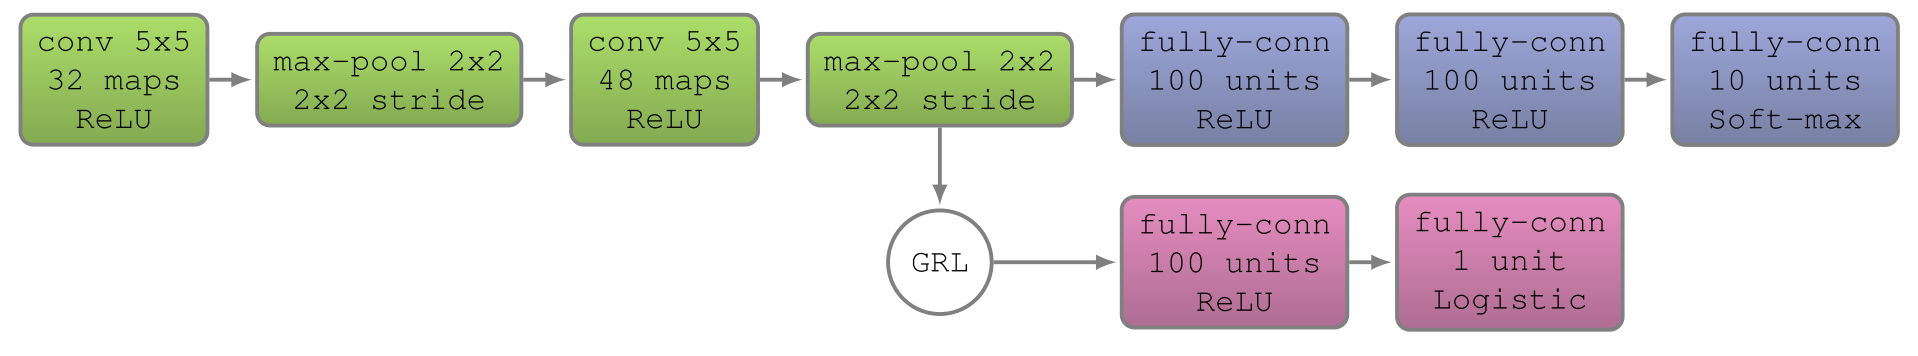

Recall: GRL is no-op in forward pass, but applies  −𝜆  factor to gradient in the backward pass.

### GRL Layer Implementation

In [76]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

### Domain Adaptation CNN Model

In [77]:

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

Wait, but why let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradualy changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [78]:
model = DACNN()
model

DACNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.5, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (class_classifier): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running

#### Checking if the model, dataloader etc. are working by sending data to untrained model

In [79]:
x0_s_train, y0_s_train = next(iter(dl_source_train))
x0_t_train, y0_t_train = next(iter(dl_target_train))


print('source domain: ', x0_s_train.shape, y0_s_train.shape)
print('target domain: ', x0_t_train.shape, y0_t_train.shape)

print(model(x0_s_train))
print(model(x0_t_train))

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])
(tensor([[-2.2205, -1.9850, -3.1341, -2.3541, -2.3479, -1.9812, -2.5227, -1.8443,
         -2.8458, -2.4581],
        [-2.7734, -1.8264, -2.3473, -2.3113, -3.2798, -2.7077, -1.9788, -1.8799,
         -2.8682, -2.0415],
        [-2.6126, -2.9733, -2.5256, -1.9602, -2.7618, -2.8453, -1.4563, -2.2684,
         -2.6648, -2.0620],
        [-2.6986, -2.2670, -2.1820, -2.1665, -2.3866, -2.5387, -2.0631, -2.1057,
         -3.0091, -2.0203]], grad_fn=<LogSoftmaxBackward0>), tensor([[-0.7514, -0.6381],
        [-0.7880, -0.6065],
        [-1.2239, -0.3482],
        [-0.3682, -1.1775]], grad_fn=<LogSoftmaxBackward0>))
(tensor([[-2.6423, -2.8283, -2.2607, -2.4046, -2.9760, -2.7861, -1.4796, -1.9608,
         -2.8348, -2.0006],
        [-2.4581, -2.2098, -2.6420, -1.7194, -2.7411, -2.3580, -2.5185, -2.0841,
         -2.4129, -2.2964],
        [-2.9227, -2.1788, -2.7004, -2.1454, -2.

### Source Training *Function*

In [80]:
### Source Training Function
from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader,optimizer,epoch):
    model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbara
    correct = 0 # for accuracy numerator
    processed =0 # for accuracy denominator

    for batch_idx, batch in enumerate(pbar):

        X_s, y_s = batch[0].to(device), batch[1].long().to(device) 
        #sending data to CPU or GPU as per device
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_pred, _ = model(X_s, grl_lambda = 0)
        loss = F.nll_loss(class_pred, y_s) # capturing loss
        # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector
        
        loss.backward() # backpropagation
        optimizer.step() # updating the params

        preds = class_pred.argmax(dim=1, keepdim=True)  # get the index olf the max log-probability
        correct += preds.eq(y_s.view_as(preds)).sum().item()

        processed += len(X_s)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


### Typical Test Function

In [81]:
## This is same as DANN test function

### DANN Training *Function*

In [82]:
# DANN Training Function

def dann_train_model(model, device, train_source_loader, train_target_loader,optimizer, epoch, num_epochs):
    model.train() # setting the model in training mode
    # understanding batch size by understanding length of two dataloaders
    len_dataloader = min(len(train_source_loader), len(train_target_loader)) # training for minimum of two dataloaders

    i = 0 # as the training progresses the alpha changes
    while i < len_dataloader -1:
        # implementation of alpha as per paper
        p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(iter(train_source_loader))
        X_s, y_s = X_s.to(device), y_s.to(device)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long).to(device) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = F.nll_loss(class_pred, y_s)
        loss_s_domain = F.nll_loss(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(iter(train_target_loader)) # ignore target domain class labels!
        X_t = X_t.to(device)
        y_t_domain = torch.ones(batch_size, dtype=torch.long).to(device) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda) # ignore the model output in terms of class labels
        loss_t_domain = F.nll_loss(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()

        if ((i + 1) % 10 == 0):
          print(f'[{i+1}/{len_dataloader}] '
                f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
              )
        
        i = i+1

### DANN Test *Function*

In [83]:
# DANN Test Function

def dann_test_model(model, device, test_loader):
    model.eval() # setting the model in evaluation mode
    grl_lambda = 0
    test_loss = 0
    correct = 0  # for accuracy numerator

    with torch.no_grad():
        for (X_t,y_t) in test_loader:
            
            X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device
            class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
            
            test_loss = F.nll_loss(class_outputs, y_t, reduction='sum').item()  # sum up batch loss
            preds = class_outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += preds.eq(y_t.view_as(preds)).sum().item()
        
        test_loss /= len(test_loader.dataset) # average test loss

            
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%) \n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

### Test and Training Declarations

In [84]:
lr = 1e-3
n_epochs = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Setup optimizer as usual

typical_model = DACNN()
typical_model = typical_model.to(device)
optimizer = optim.Adam(typical_model.parameters(), lr)

dann_model = DACNN()
dann_model = dann_model.to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr) # note the change in optimizer



batch_size = 2048

dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)
dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


cuda


### Typical Model Training and Testing Loop

In [85]:
## Typical model
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    train_model(typical_model, device, dl_source_train, optimizer, epoch)
    print('\nTesting on Source Val......')
    dann_test_model(typical_model, device, dl_source_val)
    print('\nTesting on Target Val......')
    dann_test_model(typical_model, device, dl_target_val)
print("Typical model training and validation completed")

EPOCH: 1


Loss=0.6406450867652893 Batch_id=29 Accuracy=71.53: 100%|██████████| 30/30 [00:18<00:00,  1.65it/s]



Testing on Source Val......
Test set: Average loss: 0.0896, Accuracy: 9517/10000 (95.17%) 


Testing on Target Val......
Test set: Average loss: 0.2204, Accuracy: 1331/9001 (14.79%) 

EPOCH: 2


Loss=0.2671789824962616 Batch_id=29 Accuracy=93.55: 100%|██████████| 30/30 [00:17<00:00,  1.67it/s]



Testing on Source Val......
Test set: Average loss: 0.0239, Accuracy: 9774/10000 (97.74%) 


Testing on Target Val......
Test set: Average loss: 0.2398, Accuracy: 1459/9001 (16.21%) 

Typical model training and validation completed


### DANN Training and Testing Loop

In [86]:
### DANN
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    dann_train_model(dann_model, device, dl_source_train, dl_target_train, optimizer_dann, epoch, num_epochs = n_epochs)
    print('Testing on Source Val......')
    dann_test_model(dann_model, device, dl_source_val)
    print('Testing on Target Val......')
    dann_test_model(dann_model, device, dl_target_val)
print("DANN model training and validtion completed")

EPOCH: 1
[10/29] class_loss: 1.5676 s_domain_loss: 0.6399 t_domain_loss: 0.7631 grl_lambda: 0.650 
[20/29] class_loss: 1.1671 s_domain_loss: 0.7559 t_domain_loss: 0.7206 grl_lambda: 0.927 
Testing on Source Val......
Test set: Average loss: 0.1123, Accuracy: 7798/10000 (77.98%) 

Testing on Target Val......
Test set: Average loss: 0.1947, Accuracy: 2162/9001 (24.02%) 

EPOCH: 2
[10/29] class_loss: 0.6989 s_domain_loss: 0.7747 t_domain_loss: 0.6732 grl_lambda: 0.997 
[20/29] class_loss: 0.5380 s_domain_loss: 0.5921 t_domain_loss: 0.8374 grl_lambda: 0.999 
Testing on Source Val......
Test set: Average loss: 0.0664, Accuracy: 8750/10000 (87.50%) 

Testing on Target Val......
Test set: Average loss: 0.1933, Accuracy: 2686/9001 (29.84%) 

DANN model training and validtion completed
